In [1]:
import numpy as np # We'll be storing our data as numpy arrays
import os # For handling directories
from PIL import Image # For handling the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Plotting

In [29]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
import matplotlib.pyplot as plt # for plotting
import os # provides a way of using operating system dependent functionality
import cv2 #Image handling library
import numpy as np
import keras.backend as K
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from sklearn.datasets import make_multilabel_classification
# Import of keras model and hidden layers for our convolutional network
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Conv2D, Activation, MaxPool2D, Dense, Flatten, Dropout,BatchNormalization,MaxPooling2D

In [3]:
CATEGORIES = ["01_palm", '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']
IMG_SIZE = 50

# paths for dataset
data_path = "../input/dataset/leapGestRecog/leapGestRecog"

In [4]:
# Loading the images and their class(0 - 9)
image_data = []
for dr in os.listdir(data_path):
    for category in CATEGORIES:
        class_index = CATEGORIES.index(category)    
        path = os.path.join(data_path, dr, category)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                image_data.append([cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)), class_index])
            except Exception as e:
                pass
image_data[0]

[array([[5, 4, 4, ..., 3, 4, 2],
        [5, 4, 5, ..., 3, 3, 3],
        [4, 5, 4, ..., 4, 5, 3],
        ...,
        [4, 5, 5, ..., 5, 5, 5],
        [5, 5, 6, ..., 5, 7, 4],
        [4, 7, 5, ..., 5, 4, 4]], dtype=uint8),
 0]

In [5]:
# shuffle the input data
import random
random.shuffle(image_data)

In [6]:
input_data = []
label = []
for X, y in image_data:
    input_data.append(X)
    label.append(y)
input_data[:5]

[array([[3, 4, 4, ..., 6, 4, 4],
        [4, 4, 5, ..., 6, 6, 4],
        [5, 6, 4, ..., 6, 5, 5],
        ...,
        [5, 5, 5, ..., 6, 6, 5],
        [3, 5, 5, ..., 5, 4, 4],
        [5, 6, 5, ..., 6, 6, 5]], dtype=uint8),
 array([[3, 3, 4, ..., 2, 4, 3],
        [4, 3, 3, ..., 3, 3, 4],
        [4, 3, 4, ..., 4, 3, 4],
        ...,
        [4, 4, 5, ..., 3, 3, 4],
        [3, 4, 4, ..., 4, 3, 3],
        [5, 4, 4, ..., 3, 3, 3]], dtype=uint8),
 array([[5, 6, 8, ..., 5, 5, 4],
        [7, 7, 8, ..., 5, 4, 4],
        [7, 9, 8, ..., 4, 5, 5],
        ...,
        [8, 8, 9, ..., 5, 6, 4],
        [8, 8, 8, ..., 5, 5, 6],
        [7, 8, 7, ..., 5, 6, 5]], dtype=uint8),
 array([[5, 5, 5, ..., 4, 4, 5],
        [6, 6, 5, ..., 3, 4, 4],
        [3, 5, 6, ..., 5, 5, 4],
        ...,
        [4, 5, 5, ..., 5, 5, 4],
        [5, 5, 4, ..., 5, 4, 4],
        [3, 5, 3, ..., 3, 6, 5]], dtype=uint8),
 array([[6, 4, 5, ..., 3, 4, 3],
        [4, 4, 5, ..., 5, 4, 3],
        [6, 5, 5, ..., 4, 4, 3

In [7]:
label[:10]

[1, 7, 5, 7, 5, 2, 8, 6, 6, 2]

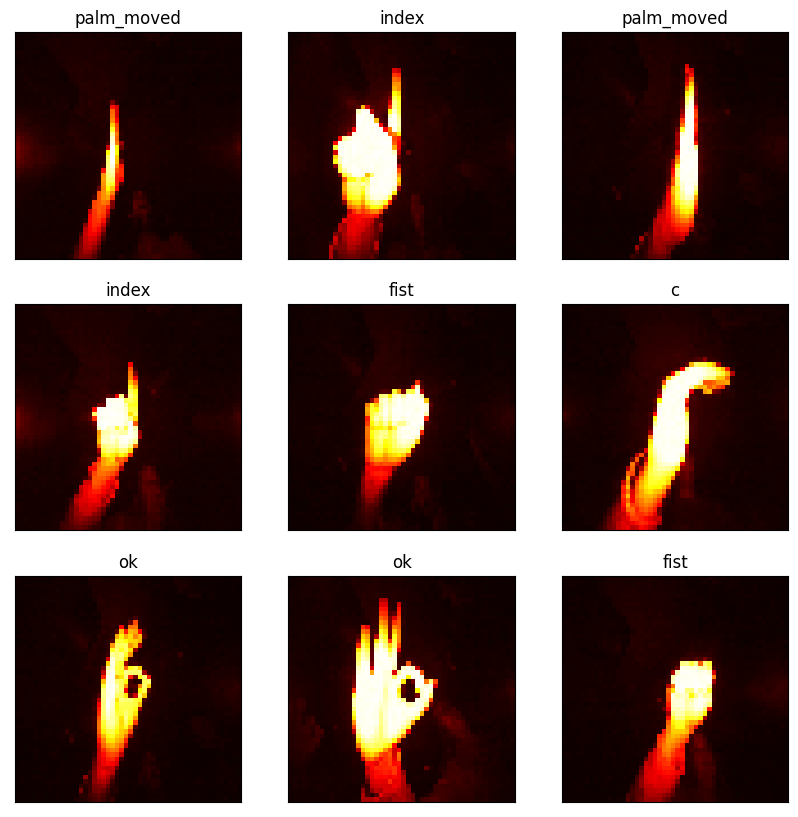

In [8]:
plt.figure(1, figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(image_data[i][0], cmap='hot')
    plt.xticks([])
    plt.yticks([])
    plt.title(CATEGORIES[label[i]][3:])
#plt.show()

In [9]:
# Normalizing the data
input_data = np.array(input_data)
label = np.array(label)
input_data = input_data/255.0
input_data.shape

(20000, 50, 50)

In [10]:
from sklearn.datasets import make_multilabel_classification
X,y=make_multilabel_classification(n_samples=500,n_features=4,n_classes=2,n_labels=3,random_state=1)
X

array([[ 9., 12.,  6., 12.],
       [ 5.,  2., 12., 22.],
       [15.,  5., 12., 11.],
       ...,
       [ 5., 10., 15., 28.],
       [ 0.,  8., 16., 27.],
       [ 6.,  9., 13., 22.]])

In [11]:
X=(X-X.min())/(X.max()-X.min())
X

array([[0.20454545, 0.27272727, 0.13636364, 0.27272727],
       [0.11363636, 0.04545455, 0.27272727, 0.5       ],
       [0.34090909, 0.11363636, 0.27272727, 0.25      ],
       ...,
       [0.11363636, 0.22727273, 0.34090909, 0.63636364],
       [0.        , 0.18181818, 0.36363636, 0.61363636],
       [0.13636364, 0.20454545, 0.29545455, 0.5       ]])

In [12]:
# one hot encoding
label = keras.utils.to_categorical(label, num_classes=10,dtype='i1')
label[0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [13]:
# reshaping the data
input_data.shape = (-1, IMG_SIZE, IMG_SIZE, 1)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_data, label, test_size = 0.10, random_state=0)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.10)
# X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

In [15]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [16]:

classes, counts = np.unique(y_train, return_counts=True)

classes

array([0, 1], dtype=int8)

In [17]:
# # Plotting class distribution
# plt.barh(CATEGORIES, counts)
# plt.title('Class distribution in training set')
# plt.xlabel('Count')
# plt.ylabel('Classes')
# plt.show()

In [19]:
# Ukuran input gambar (misalnya 227x227x3 untuk RGB)
input_shape = (50, 50, 1)

# Membuat model
model = Sequential()

# Layer 1: Convolutional Layer
model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(2, 2), padding='valid', input_shape=input_shape, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))

# Layer 2: Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))

# Layer 3: Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'))

# Layer 4: Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'))

# Layer 5: Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))

# Flattening Layer
model.add(Flatten())

# Layer 6: Fully Connected Layer
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

# Layer 7: Fully Connected Layer
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

# Layer 8: Output Layer
# Ganti '10' dengan jumlah kelas yang Anda miliki
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), metrics=['accuracy'])

# Ringkasan model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 20, 20, 96)        11712     
                                                                 
 batch_normalization_2 (Batc  (None, 20, 20, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 9, 9, 96)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 9, 256)         614656    
                                                                 
 batch_normalization_3 (Batc  (None, 9, 9, 256)        1024      
 hNormalization)                                                 
                                                      

In [20]:
r = model.fit(X_train, y_train, epochs = 7, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/7
563/563 [==============================] - 176s 311ms/step - loss: 0.3938 - accuracy: 0.8616 - val_loss: 0.6148 - val_accuracy: 0.8410
Epoch 2/7
563/563 [==============================] - 146s 259ms/step - loss: 0.0193 - accuracy: 0.9943 - val_loss: 0.0024 - val_accuracy: 0.9995
Epoch 3/7
563/563 [==============================] - 146s 259ms/step - loss: 0.0050 - accuracy: 0.9988 - val_loss: 0.2655 - val_accuracy: 0.9540
Epoch 4/7
563/563 [==============================] - 152s 271ms/step - loss: 0.0243 - accuracy: 0.9946 - val_loss: 0.0017 - val_accuracy: 0.9990
Epoch 5/7
563/563 [==============================] - 148s 262ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.0463 - val_accuracy: 0.9865
Epoch 6/7
563/563 [==============================] - 151s 269ms/step - loss: 0.0266 - accuracy: 0.9929 - val_loss: 4.1840e-05 - val_accuracy: 1.0000
Epoch 7/7
563/563 [==============================] - 143s 254ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 2.5392e-05 

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 20, 20, 96)        11712     
                                                                 
 batch_normalization_2 (Batc  (None, 20, 20, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 9, 9, 96)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 9, 256)         614656    
                                                                 
 batch_normalization_3 (Batc  (None, 9, 9, 256)        1024      
 hNormalization)                                                 
                                                      

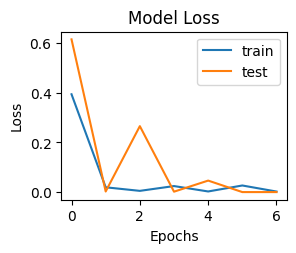

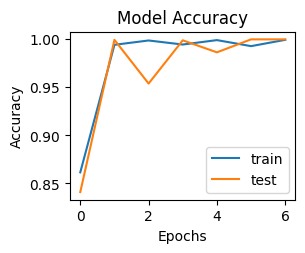

In [22]:
plt.subplot(2, 2, 1)
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [23]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_accuracy*100))

63/63 [==============================] - 2s 36ms/step - loss: 2.5392e-05 - accuracy: 1.0000
Test accuracy: 100.00%


In [24]:
# val_loss, val_accuracy = model.evaluate(X_val, y_val)

# print('Val accuracy: {:2.2f}%'.format(val_accuracy*100))

63/63 [==============================] - 2s 36ms/step


[]

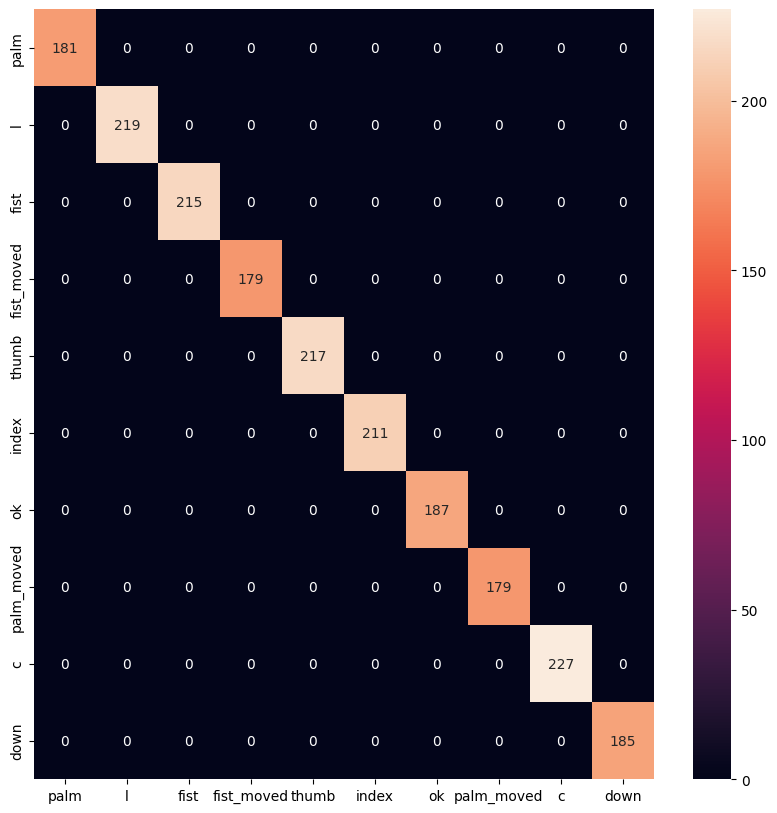

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cat = [c[3:] for c in CATEGORIES]
plt.figure(figsize=(10,10))
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
sn.heatmap(cm, annot=True,fmt='d',xticklabels=cat, yticklabels=cat)
plt.plot()

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
[[3.01065314e-16 1.00000000e+00 9.63595930e-17 ... 1.26622267e-15
  2.09432825e-19 9.06871366e-22]
 [4.87033464e-33 0.00000000e+00 8.40908692e-33 ... 9.54061026e-31
  1.00000000e+00 1.46292141e-31]
 [2.01453160e-10 1.09301899e-11 8.14384649e-09 ... 1.97807062e-10
  3.62094603e-08 1.09524625e-10]
 ...
 [1.80251682e-11 2.76892157e-14 1.60376348e-11 ... 1.03917791e-10
  1.00000000e+00 6.19238619e-11]
 [4.65116834e-12 1.52324086e-17 1.34865198e-17 ... 2.12385838e-12
  5.75984301e-14 5.09812516e-13]
 [1.00000000e+00 2.76165040e-20 4.94243640e-15 ... 2.01878546e-14
  1.47128342e-15 3.09673337e-12]]


In [42]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

63/63 [==============================] - 2s 32ms/step


In [43]:



print('Test accuracy: {:2.2f}%'.format(test_accuracy*100))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1)))

Test accuracy: 100.00%
63/63 [==============================] - 2s 39ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       181
           1       1.00      1.00      1.00       219
           2       1.00      1.00      1.00       215
           3       1.00      1.00      1.00       179
           4       1.00      1.00      1.00       217
           5       1.00      1.00      1.00       211
           6       1.00      1.00      1.00       187
           7       1.00      1.00      1.00       179
           8       1.00      1.00      1.00       227
           9       1.00      1.00      1.00       185

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



1/1 [==============================] - 0s 34ms/step


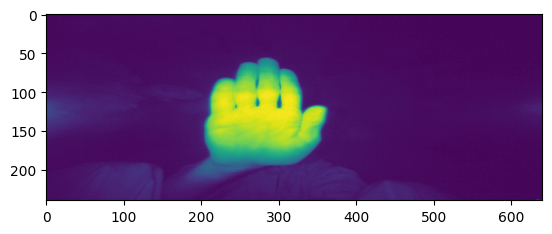

Label : palm


In [47]:
# Load the image and resize it to 32x32 pixels
image1 = Image.open('image/ut.png')
#image = Image.open('/content/asd.jpg')
image = image1.convert('L')
image = image.resize((50, 50))
plt.imshow(image)
# Convert the image to a numpy array and normalize its values
image_array = np.array(image) / 255.0


image_array = image_array.reshape((1, 50, 50, 1))  


# Pass the image through the model to get the predicted class probabilities
predictions = model.predict(image_array)

# Get the index of the predicted class with the highest probability
predicted_class = np.argmax(predictions[0])

if predicted_class == 0 :
    label = "palm"
else :
    label = "No Palm"

# label = CATEGORIES[predicted_class]



plt.imshow(image1)
plt.show()

print("Label :", label)



